Adithya Palle \
March 30, 2025 \
Final Project

Jupyter Notebook for running CNN and optical flow models on the stream of data and determining classfication accuracy.

In [1]:
from data_extraction import get_video_data, FIRE_VIDEOS_DATA_PATH
import os

In [2]:
val_fire_videos, val_no_fire_videos = get_video_data(os.path.join(FIRE_VIDEOS_DATA_PATH, "validation"))
test_fire_videos, test_no_fire_videos = get_video_data(os.path.join(FIRE_VIDEOS_DATA_PATH, "test"))


In [3]:
import random
from video_model import VideoModel, VideoModelFromImageModel
from cnn import CNNFireDetector
from train_cnn import InferenceModel, TrainingModel, TRANSFORM

# Load models


# TODO: initialize your models here


class DummyModel(VideoModel):

    def predict_on_last_frame(self, frames):
        # random prob between 0 and 1
        return random.uniform(0, 1)



my_image_model : VideoModel = VideoModelFromImageModel(CNNFireDetector.load_from_file(InferenceModel(TrainingModel()), "test_model2.pth"))
google_net : VideoModel = DummyModel()
alex_net : VideoModel = DummyModel()
optical_flow_model : VideoModel = DummyModel()

Number of parameters in the model: 1563929


In [4]:
from prediction import get_predictions, get_false_positive_rate, get_recall, get_accuracy
CHOSEN_MODEL = my_image_model
# TODO: run all the below code for each model separately and compare results (make function)
val_fire_predictions = get_predictions(CHOSEN_MODEL, val_fire_videos)
val_no_fire_predictions = get_predictions(CHOSEN_MODEL, val_no_fire_videos)






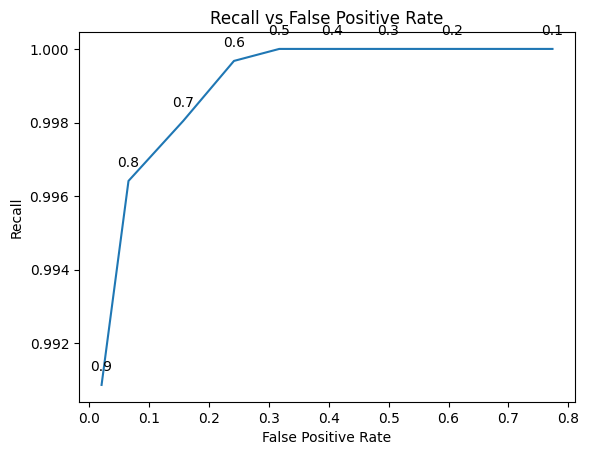

In [5]:
# use recall and FPR curve to determine best threshold for binarizing predictions
recalls = []
fprs = []
thresholds = [n/100 for n in range(0, 101, 5)] # threshold above which a prediction probabiltiy is considered fire
for threshold in thresholds:
    recall = get_recall(val_fire_predictions, threshold)
    false_positive_rate = get_false_positive_rate(val_no_fire_predictions, threshold)
    recalls.append(recall)
    fprs.append(false_positive_rate)


# plot recall vs false positive rate
import matplotlib.pyplot as plt
plt.plot(fprs, recalls)

# add point lables with threshold
for i, txt in enumerate(thresholds):
    plt.annotate(txt, (fprs[i], recalls[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall vs False Positive Rate')
plt.show()

In [6]:
best_threshold = 0.9 # TODO:  manually choose the best threshold based on the plot


# get results on test videos
test_fire_predictions = get_predictions(my_image_model, test_fire_videos)
test_no_fire_predictions = get_predictions(my_image_model, test_no_fire_videos)
test_recall = get_recall(test_fire_predictions, best_threshold)
test_fpr = get_false_positive_rate(test_no_fire_predictions, best_threshold)
test_accuracy = get_accuracy(test_fire_predictions, test_no_fire_predictions, best_threshold) # TODO: fix
print("Test Accuracy: ", test_accuracy)
print("Test Recall: ", test_recall)
print("Test False Positive Rate: ", test_fpr)

Test Accuracy:  0.9837830989484353
Test Recall:  0.9908675799086758
Test False Positive Rate:  0.020716801325875285


In [7]:
import os
import cv2
import numpy as np

# Create output folder if it doesn't exist
os.makedirs("data", exist_ok=True)

def save_video(frames, predictions, filename, threshold=0.5, fps=30):
    _ , h, w = np.array(frames[0]).shape
    out_path = os.path.join("data", filename)
    fourcc = cv2.VideoWriter_fourcc(*"avc1")  # use 'avc1' or 'XVID' if mp4v fails
    writer = cv2.VideoWriter()
    succes  = writer.open(out_path, fourcc, fps, (w, h))
    if not succes:
        raise Exception(f"Could not open video writer for {out_path}")
    for i, frame in enumerate(frames):
        # frame is in (C,H,W) format
        frame = frame.permute(1, 2, 0).numpy()  # convert (C, H, W) -> (H, W, C)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        text = "Fire" if predictions[i] >= threshold else "No Fire"
        color = (0, 0, 255) if text == "Fire" else (0, 255, 0)
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        writer.write(frame)

    writer.release()
    print(f"Saved: {out_path}")

# Save the first fire and no-fire videos
save_video(test_fire_videos[0], test_fire_predictions[0], "fire_video.mp4")
save_video(test_no_fire_videos[0], test_no_fire_predictions[0], "no_fire_video.mp4")



/tmp/ipykernel_3459/3706414200.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  _ , h, w = np.array(frames[0]).shape
[ERROR:0@66.084] global cap_ffmpeg_impl.hpp:3203 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@66.084] global cap_ffmpeg_impl.hpp:3281 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter


Exception: Could not open video writer for data/fire_video.mp4